In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from Config import Config 


In [2]:
min_date = pd.to_datetime("2020-08-09")
max_date = pd.to_datetime("2021-04-01")

In [6]:
prisoners_f = "../processed_data/viasna_data/viasna_political_prisoners.csv"
prisoners = pd.read_csv(prisoners_f)

# An incident means detention (including at the border), drawing up a report, search, etc.
incedents_f = "../processed_data/viasna_data/persecutionDatabase.csv"
incedents = pd.read_csv(incedents_f)

In [33]:
incedents.head()

,No,date_of_incident,name,gender,article,court_date,judge,court,arrest,penalty,additionally
0,1,2021-08-01,Тарайкоўская Ю.Г.,ж,24.23 ч.1 КаАП – «парушэньне парадку арганізац...,2021-08-02,Лукашэвіч Дзмітры,"Менск, Фрунзенскі",NaN,,NaN
1,2,2021-08-01,Радзько Алена,ж,24.23 ч.1 КаАП – «парушэньне парадку арганізац...,2021-08-02,Мотыль Таццяна,"Менск, Маскоўскі",15 сут.,,10.04.1961 г.н.
2,3,2021-08-01,Лапенка А.В.,NaN,24.23 ч.1 КаАП – «парушэньне парадку арганізац...,2021-08-02,Шаціла Сяргей,"Менск, Савецкі",NaN,,На дапрацоўку.
3,4,2021-07-31,Меркіс Яўген,м,23.5 КаАП – «парушэньне заканадаўства пра друк...,2021-08-02,NaN,"Гомель, Савецкі",NaN,"25 б.в. 725,00 руб.","За працу на тэлеканал ""Белсат"" без акрэдытацыі."
4,5,2021-07-31,Гурыновіч Павел,м,NaN,NaN,NaN,Менск,NaN,,NaN


In [34]:
incedents.court = incedents.court.str.strip()
incedents.name = incedents.name.str.strip()
incedents.article = incedents.article.str.strip()
incedents.judge = incedents.judge.str.strip()
incedents.arrest = incedents.arrest.str.strip()
incedents.penalty = incedents.penalty.str.strip()
incedents.additionally = incedents.additionally.str.strip()



In [44]:
incedents.court.value_counts().reset_index().to_csv("../processed_data/viasna_data/court_names.csv", index=False)

In [35]:
incedents.to_csv("../processed_data/viasna_data/persecutionDatabase_copy.csv")


In [7]:
# create date time 
prisoners.date_of_detention = pd.to_datetime(prisoners.date_of_detention)
incedents.date_of_incident = pd.to_datetime(incedents.date_of_incident)

# filter by date
prisoners_date_filt = (prisoners.date_of_detention >= min_date) & (prisoners.date_of_detention <= max_date)
prisoners_filt = prisoners.loc[prisoners_date_filt, :]

incedents_date_filt = (incedents.date_of_incident >= min_date) & (incedents.date_of_incident <= max_date)
incedents_filt = incedents.loc[incedents_date_filt, :]

In [8]:
# Daily number of prisoners
daily_num_prisoners = (
    prisoners_filt
    .groupby("date_of_detention")["name"]
    .count()
    .reset_index()
    .rename(columns={"date_of_detention": "date" ,"name": "num_prisoners"})
    )

# Daily number of incidents
daily_num_incedents = (
    incedents_filt
    .groupby("date_of_incident")["name"]
    .count()
    .reset_index()
    .rename(columns={"date_of_incident": "date","name": "num_incidents"})
    )

In [9]:
# add any missing days between min/max to the dataset
all_days = pd.date_range(min_date, max_date, freq='D')

# check for missing days and fill the num_detentions column with 0 
daily_num_prisoners = ( 
    daily_num_prisoners
    .set_index("date") 
     .reindex(all_days) # reindex using all_days - this adds any missing days to the dataset 
     .rename_axis(['date'])
     .fillna(0)
     .reset_index()
)

# check for missing days and fill the num_detentions column with 0 
daily_num_incedents = ( 
    daily_num_incedents
    .set_index("date") 
     .reindex(all_days) # reindex using all_days - this adds any missing days to the dataset 
     .rename_axis(['date'])
     .fillna(0)
     .reset_index()
)

In [10]:
# merge prisoners and incidents
df_merge = daily_num_prisoners.merge(daily_num_incedents, how="left", on="date")

In [11]:
# Day of week 
df_merge["day_of_week"] = df_merge.date.dt.day_name()

In [14]:
df_merge.head(10)

,date,num_prisoners,num_incidents,day_of_week
0,2020-08-09,5.0,3630.0,Sunday
1,2020-08-10,18.0,1799.0,Monday
2,2020-08-11,7.0,1093.0,Tuesday
3,2020-08-12,6.0,274.0,Wednesday
4,2020-08-13,3.0,48.0,Thursday
5,2020-08-14,3.0,12.0,Friday
6,2020-08-15,2.0,8.0,Saturday
7,2020-08-16,0.0,10.0,Sunday
8,2020-08-17,1.0,10.0,Monday
9,2020-08-18,5.0,2.0,Tuesday


<AxesSubplot:>

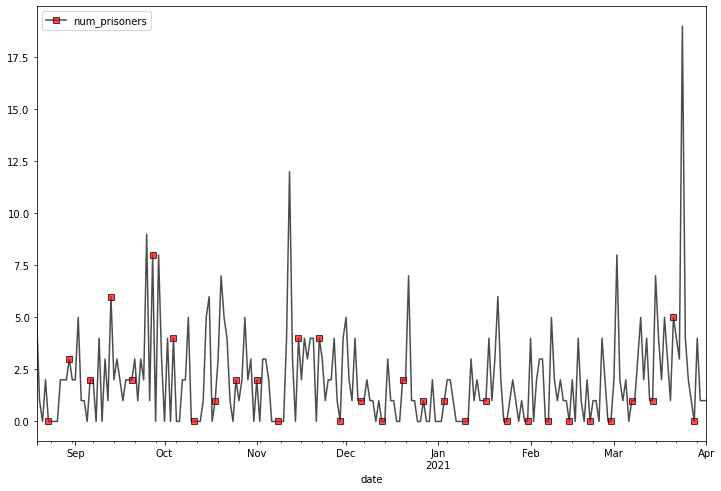

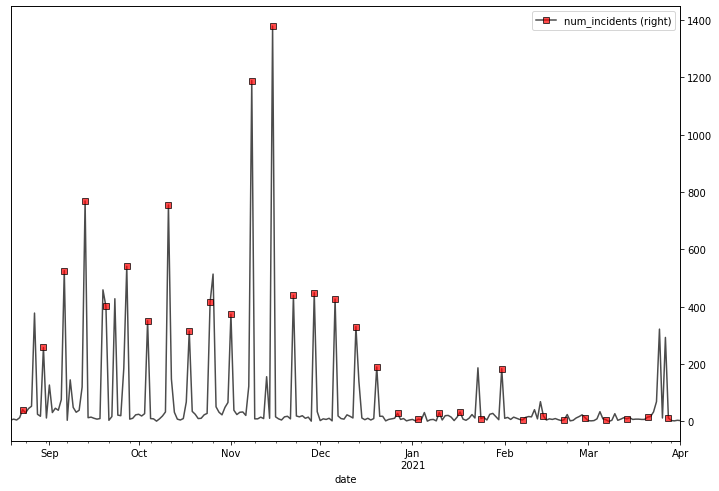

In [20]:
ax1 = df_merge.loc[10:].plot(
    x="date", 
    y="num_prisoners",
    figsize=(12,8),
    style='s-',
    color="black", 
    mfc = "red",  
    alpha=0.7,  
    markevery = np.where(df_merge["day_of_week"].loc[10:] == "Sunday", True, False)
    )

df_merge.loc[10:].plot(
    x="date", 
    y="num_incidents",
    figsize=(12,8),
    style='s-', 
    color="black", 
    mfc = "red",   
    alpha=0.7, 
    secondary_y=True,
    markevery = np.where(df_merge["day_of_week"].loc[10:] == "Sunday", True, False),
    )



In [26]:
df_merge.sort_values(by="num_incidents", ascending=False).head(10)

,date,num_prisoners,num_incidents,day_of_week
0,2020-08-09,5.0,3630.0,Sunday
1,2020-08-10,18.0,1799.0,Monday
98,2020-11-15,4.0,1379.0,Sunday
91,2020-11-08,0.0,1189.0,Sunday
2,2020-08-11,7.0,1093.0,Tuesday
35,2020-09-13,6.0,769.0,Sunday
63,2020-10-11,0.0,755.0,Sunday
49,2020-09-27,8.0,541.0,Sunday
28,2020-09-06,2.0,526.0,Sunday
78,2020-10-26,1.0,514.0,Monday


In [32]:
# save data
f_name = "viasna_dailyCounts_Aug_March.csv"
path = os.path.join(Config.proccessed_data_dir, Config.viasna_data_subdir, f_name)
df_merge.to_csv(path, index=False)

In [ ]:
# https://apnews.com/article/belarus-alexander-lukashenko-minsk-archive-elections-038f05df4d1fa275e648acc624467171
# detention v/s arrests: https://www.thomasianlaw.com/blog/2022/september/what-s-the-difference-between-a-detention-and-an/
# Detainment may lead to arrest
